#Simplest Color Balance
This notebook represents experiments with the algorithm <b>"Simplest Color Balance"</b> described at http://www.ipol.im/pub/art/2011/llmps-scb/ . Mainly these experiments are related to adaptation of this algorithm to the retina project.

In [2]:
import os, sys
import skimage
from skimage import io, util
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.append(os.getcwd())
from cicrularcrop import *

Load an image

In [4]:
baseFolder = '/Users/vtymchenko/Dropbox/Shared/Retina'
imgFile = '2/129_right.jpeg'
#imgFile = 'crop/20677_left.jpeg'

filename = os.path.join(baseFolder, imgFile)
img = skimage.io.imread(filename)

crop it

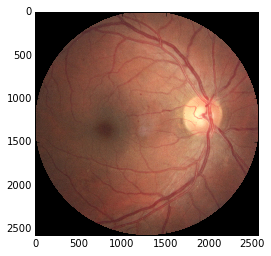

In [5]:
(img, mask, x, y, r) = circularcrop(img)
plt.imshow(img)

##Method Description
Our input image is an array of $N$ numeric values in the $[min, max]$ interval. The output is a corrected array of the $N$ updated numeric values. _Multiple channel images are processed independently on each channel with the same method._

We will perform a color balance on this data where we have saturated a percentage $s_1%$ of the pixels on the left side of the histogram, and a percentage $s_2%$ of pixels on the right side; for example, $s_1=0$ and $s_2=3$ means that this balance will saturate no pixels at the beginning and will saturate at most $N\frac{3}{100}$ at the end of the histogram. We can't ensure that exactly $N\frac{s_1+s_2}{100}$ pixels are saturated because the pixel value distribution is discrete.



##Sorting

The saturation extrema $V_{min}$ and $V_{max}$ can be seen as quantiles of the pixel values distribution, e.g. first and 99th centiles for a 2% saturation.

Thus, an easy way to compute $V_{min}$ and $V_{max}$ is to sort the pixel values, and pick the quantiles from the sorted array. This algorithm would be described as follow:

* <b>sort the pixel values</b> The original values must be kept for further transformation by the bounded affine function, so the $N$ pixels must first be copied before sorting.
* <b>pick the quantiles</b> From the sorted pixels with a saturation level $s=s_1+s_2$ in $[0, 100]$, we want to saturate $N \frac{s}{100}$ pixels, so $V_{min}$ and $V_{max}$ are taken from the sorted array at positions $N\frac{s_1} {100}$ and $N(1 - \frac{s_2}{100}) - 1$.
* <b>saturate the pixels</b> According to the previous definitions of $V_{min}$ and $V_{max}$, the number of pixels with values lower than $V_{min}$ or higher than $V_{max}$ is at most $N\frac{s}{100}$. The pixels (in the original unsorted array) are updated to $V_{min}$ (resp. $V_{max}$) if their value is lower than $V_{min}$ (resp. higher than $V_{max}$).
* <b>affine transform</b> The image is scaled to $[min, max]$ with a transformation of the pixel values by the function $f$ such that $f(x) = (x - V_{min})\frac{max - min}{V_{max} - V_{min}} + min$.


In [6]:
img_r = img[:,:,0].flatten()
h, bins = np.histogram(img_r,bins=256,range=(0,255))


In [7]:
print img.shape, mask.shape

(2570, 2570, 3) (2570, 2570)


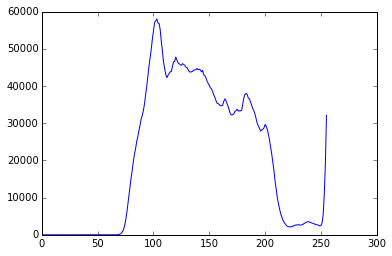

In [8]:
h[0] -= np.sum(1 - mask)
plt.plot(h)

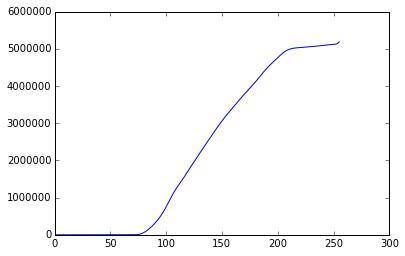

In [9]:
histo = np.cumsum(h)
plt.plot(histo)

In [10]:
s1 = 1.
s2 = 1.

In [11]:
# search vmin and vmax
N = len(img_r)
vmin = 0
while histo[vmin + 1] <= N * s1 / 100:
    vmin = vmin + 1

In [12]:
vmax = 255 - 1
while histo[vmax - 1] > N * (1 - s2 / 100):
    vmax = vmax - 1
if vmax < 255 - 1:
    vmax = vmax + 1

In [13]:
scale = 255. / (vmax - vmin)
img_r = np.maximum(img_r, vmin) # saturate values smaller than the minimal
img_r = np.minimum(img_r, vmax) # saturater values larger than vmax
img_r = (img_r - vmin) * scale
img_r = np.array(img_r, dtype=int)
img_r = np.reshape(img_r, img[:,:,0].shape)


Now combine everything together

In [17]:
def cbalance(img, s1, s2):
    
    img_f = img.flatten()
    h, bins = np.histogram(img_f,bins=256,range=(0,255))
    histo = np.cumsum(h)    
    N = len(img_f)
    
    vmin = 0
    while histo[vmin + 1] <= N * s1 / 100:
        vmin = vmin + 1
    vmax = 255 - 1
    while histo[vmax - 1] > N * (1 - s2 / 100):
        vmax = vmax - 1
    if vmax < 255 - 1:
        vmax = vmax + 1
        
    scale = 255. / (vmax - vmin)

    img_f = np.maximum(img_f, vmin) # saturate values smaller than the minimal
    img_f = np.minimum(img_f, vmax) # saturater values larger than vmax
    img_f = (img_f - vmin) * scale
    img_f = np.array(img_f, dtype=int)
    img_f = np.reshape(img_f, img.shape)

    return img_f

def colorbalance(img,s1, s2):
    img1 = np.zeros(img.shape)

    img1[:,:,0] = cbalance(img[:,:,0], 1, 1)
    img1[:,:,1] = cbalance(img[:,:,1], 1, 1)
    img1[:,:,2] = cbalance(img[:,:,2], 1, 1)
    
    return img1

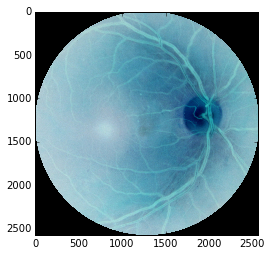

In [18]:
img1 = colorbalance(img, 1, 1)

plt.imshow(img1)

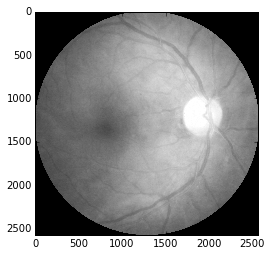

In [19]:
plt.imshow(img1[:,:,0], cmap='gray')